In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [2]:
data_dir = "../data/"
os.listdir(data_dir)

['best_model_3.pt',
 '.ipynb_checkpoints',
 'load_data.sh',
 'sample_submission.csv',
 'train_np',
 'best_model_4.pt',
 'train_fp.csv',
 'train',
 'train_tp_folds.csv',
 'train_tp_folds_v3.csv',
 'best_model_0.pt',
 'best_model_1.pt',
 'best_model_2.pt',
 'soundnet8_final.pth',
 'train_tp.csv',
 'train_tp_folds_v2.csv',
 'test']

In [3]:
train_tp = pd.read_csv(os.path.join(data_dir, "train_tp.csv"))
train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [4]:
train_tp["duration"] = (train_tp.t_max - train_tp.t_min)
train_tp["f_range"] = (train_tp.f_max - train_tp.f_min)
train_tp["f_mean"] = (train_tp.f_max + train_tp.f_min) / 2.

In [5]:
train_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 10 columns):
recording_id    1216 non-null object
species_id      1216 non-null int64
songtype_id     1216 non-null int64
t_min           1216 non-null float64
f_min           1216 non-null float64
t_max           1216 non-null float64
f_max           1216 non-null float64
duration        1216 non-null float64
f_range         1216 non-null float64
f_mean          1216 non-null float64
dtypes: float64(7), int64(2), object(1)
memory usage: 95.1+ KB


# Длительноть сигнала

/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


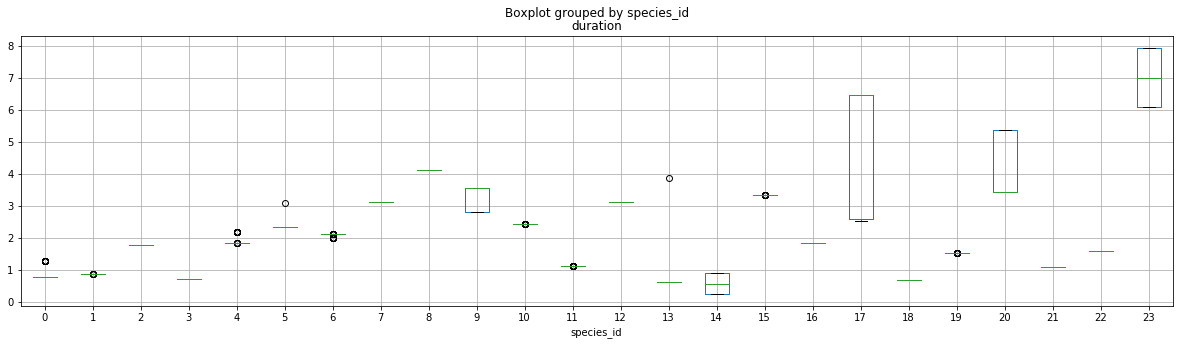

In [6]:
train_tp.boxplot(column="duration", by='species_id', figsize=(20, 5))
plt.show()

# разделить классы на 2 группы 0-1, 1-2, 2-4 и 4-8с
# максимальная длина посделовательности 8 с

def get_group(x):
    if x < 1: return 0
    if x < 2: return 1
    if x < 4: return 2
    if x < 8: return 3
    else: raise ValueError

groups = train_tp.groupby("species_id")["duration"].mean().apply(get_group)
groups_df = pd.DataFrame(groups).rename(columns={"duration": "duration_group"})
train_tp = train_tp.join(groups_df, on="species_id", how="left")

# Частоты сигналов

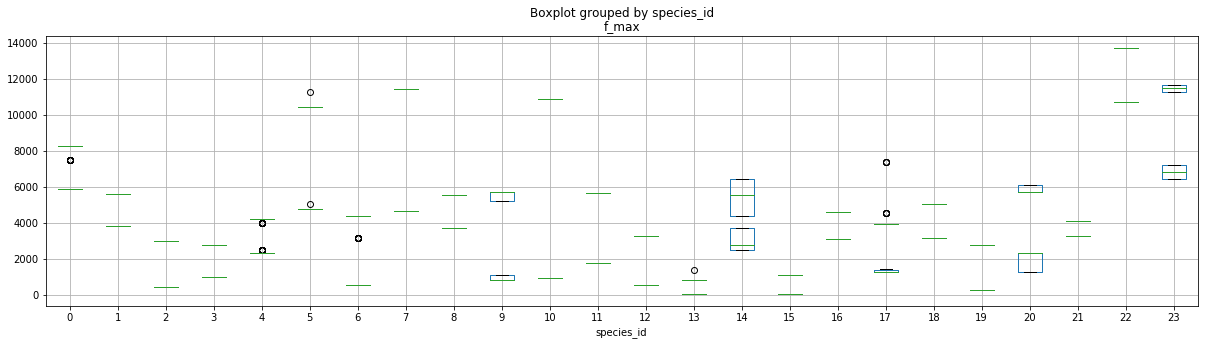

In [7]:
ax = train_tp.boxplot(column="f_min", by='species_id', figsize=(20, 5))
train_tp.boxplot(column="f_max", by='species_id', figsize=(20, 5), 
                 ax=ax, boxprops=dict(color="red"), medianprops=dict(color="red"))
plt.show()

In [8]:
min_f = train_tp.groupby("species_id")["f_min"].min().to_dict()
max_f = train_tp.groupby("species_id")["f_max"].max().to_dict()

def get_non_overlapped_classes(cls_id):
    cls_f_min = min_f[cls_id]
    cls_f_max = max_f[cls_id]
    non_overlapped_classes = []
    for cur_cls_id in min_f.keys():
        if cls_id == cur_cls_id:
            continue
        if cls_f_min > max_f[cur_cls_id] or cls_f_max < min_f[cur_cls_id]:
            non_overlapped_classes.append(cur_cls_id)
    return non_overlapped_classes

train_tp["non_overlapping_classes"] = train_tp["species_id"].apply(get_non_overlapped_classes)

In [9]:
data = {i: get_non_overlapped_classes(i) for i in range(24)}
data

{0: [1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 15, 16, 18, 19, 21, 22],
 1: [0, 2, 3, 12, 13, 15, 19, 22, 23],
 2: [0, 1, 5, 7, 8, 16, 18, 21, 22, 23],
 3: [0, 1, 5, 7, 8, 16, 18, 21, 22, 23],
 4: [0, 5, 7, 13, 15, 22, 23],
 5: [2, 3, 4, 6, 12, 13, 15, 16, 19, 21],
 6: [0, 5, 7, 22, 23],
 7: [2, 3, 4, 6, 12, 13, 15, 16, 19, 21],
 8: [0, 2, 3, 12, 13, 15, 19, 22, 23],
 9: [0, 22, 23],
 10: [],
 11: [0, 13, 15, 22, 23],
 12: [0, 1, 5, 7, 8, 22, 23],
 13: [0, 1, 4, 5, 7, 8, 11, 14, 16, 18, 21, 22, 23],
 14: [13, 15, 22],
 15: [0, 1, 4, 5, 7, 8, 11, 14, 16, 17, 18, 20, 21, 22, 23],
 16: [0, 2, 3, 5, 7, 13, 15, 19, 22, 23],
 17: [15, 22],
 18: [0, 2, 3, 13, 15, 19, 22, 23],
 19: [0, 1, 5, 7, 8, 16, 18, 21, 22, 23],
 20: [15, 22, 23],
 21: [0, 2, 3, 5, 7, 13, 15, 19, 22, 23],
 22: [0, 1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 23: [1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 15, 16, 18, 19, 20, 21]}

In [10]:
train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,duration,f_range,f_mean,duration_group,non_overlapping_classes
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,0.5867,3000.000,4031.2500,0,"[13, 15, 22]"
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,6.0837,4048.240,9259.2800,3,"[1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 15, 16, 18, ..."
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,3.1360,2718.750,1921.8750,2,"[0, 1, 5, 7, 8, 22, 23]"
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,3.7790,3100.780,3014.6500,3,"[15, 22]"
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,2.4439,9905.239,5900.0805,2,[]


# Появление в одной записи

In [11]:
# number of detections per sample
train_tp.recording_id.count() / len(train_tp.recording_id.unique())

1.0742049469964665

In [12]:
from collections import defaultdict

d = defaultdict(list)
for i, row in train_tp[["recording_id", "species_id"]].iterrows():
    d[row["recording_id"]].append(row["species_id"])

array = np.zeros([len(d), 24])
for i, (record, species) in enumerate(d.items()):
    for sp in species:
        array[i, sp] = 1

In [13]:
import seaborn as sn

columns = range(24)
df_cm = pd.DataFrame(array.T @ array, index=columns, columns=columns)

plt.figure(figsize=(12, 10))
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, linewidths=1, linecolor="white", square=True)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
train_tp.info()

In [ ]:
from collections import Counter, defaultdict

import numpy as np

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state


class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.

    This cross-validation object is a variation of StratifiedKFold that returns
    stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.

    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).

    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.

    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [2 2 4 5 5 5 5 6 6 7]
           [1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 3 3 3 8 8]
           [0 0 1 1 1 0 0]
    TRAIN: [1 1 3 3 3 4 5 5 5 5 8 8]
           [0 0 1 1 1 1 0 0 0 0 0 0]
     TEST: [2 2 6 6 7]
           [1 1 0 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]

    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).

    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    # Implementation based on this kaggle kernel:
    # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
    def _iter_test_indices(self, X, y, groups):
        labels_num = np.max(y) + 1
        y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
        y_distr = Counter()
        for label, group in zip(y, groups):
            y_counts_per_group[group][label] += 1
            y_distr[label] += 1

        y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
        groups_per_fold = defaultdict(set)

        groups_and_y_counts = list(y_counts_per_group.items())
        rng = check_random_state(self.random_state)
        if self.shuffle:
            rng.shuffle(groups_and_y_counts)

        for group, y_counts in sorted(groups_and_y_counts,
                                      key=lambda x: -np.std(x[1])):
            best_fold = None
            min_eval = None
            for i in range(self.n_splits):
                y_counts_per_fold[i] += y_counts
                std_per_label = []
                for label in range(labels_num):
                    std_per_label.append(np.std(
                        [y_counts_per_fold[j][label] / y_distr[label]
                         for j in range(self.n_splits)]))
                y_counts_per_fold[i] -= y_counts
                fold_eval = np.mean(std_per_label)
                if min_eval is None or fold_eval < min_eval:
                    min_eval = fold_eval
                    best_fold = i
            y_counts_per_fold[best_fold] += y_counts
            groups_per_fold[best_fold].add(group)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group in enumerate(groups)
                            if group in groups_per_fold[i]]
            yield test_indices

In [ ]:
n_folds = 6
k_fold = StratifiedGroupKFold(n_splits=6)

splits = k_fold.split(train_tp.index, train_tp.species_id, groups=train_tp.recording_id)
folds = np.zeros(len(train_tp), dtype=int)
for i, (_, indexes) in enumerate(splits):
    for index in indexes:
        folds[index] = i

train_tp["fold"] = folds

In [ ]:
# check recording_id leak
for i in range(n_folds):
    for j in range(n_folds):
        if i != j:
            assert not (
                set(train_tp[train_tp.fold == i].recording_id.values)
                    .intersection(
                        set(train_tp[train_tp.fold == j].recording_id.values)
                    )
            )

In [1]:
train_tp.to_csv("../data/train_tp_folds_v3.csv", index=False)

NameError: name 'train_tp' is not defined

In [ ]:
# saving results
folds_ids = list(range(6)) * 1000
train_tp = train_tp.sort_values("species_id")
train_tp["fold"] = folds_ids[:len(train_tp)]
train_tp.head()

# Visualization

In [58]:
audio, sample_rate = librosa.load("../data/train/006ab765f.flac", sr = None)

In [61]:
train_tp[train_tp["recording_id"] == "006ab765f"]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,duration,f_range,f_mean,duration_group,non_overlapping_classes
1,006ab765f,23,1,39.9615,7235.16,46.0452,11283.4,6.0837,4048.24,9259.28,3,"[1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 15, 16, 18, ..."


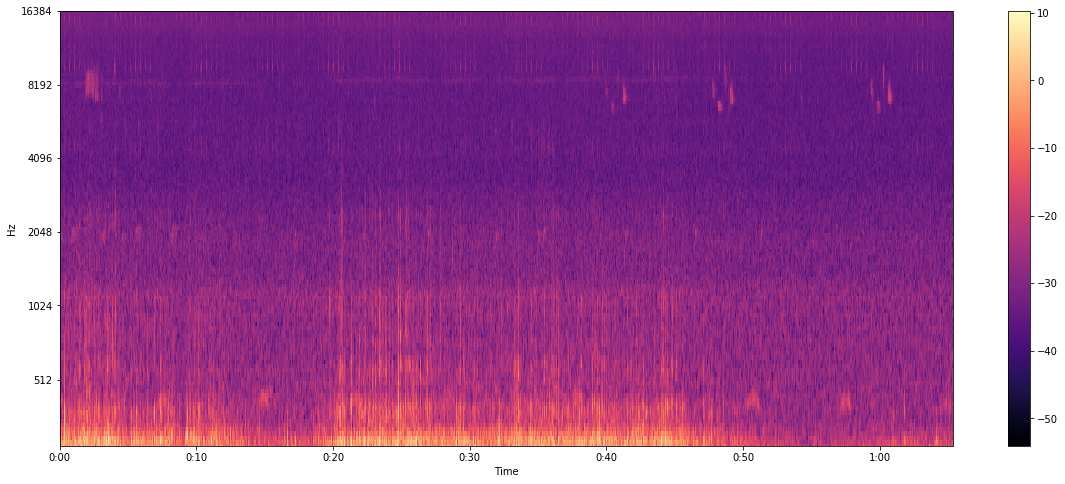

In [62]:
mel_kwargs = dict(n_fft=2048, hop_length=512, sr=44100, power=1.5, fmin=64, fmax=16384)

plt.figure(figsize=(20,8))
mel = librosa.feature.melspectrogram(audio, **mel_kwargs)
mel = librosa.power_to_db(mel)
librosa.display.specshow(mel, sr=mel_kwargs["sr"], fmin=mel_kwargs["fmin"], fmax=mel_kwargs["fmax"], y_axis="mel", x_axis="time")
plt.colorbar()

(128, 135)


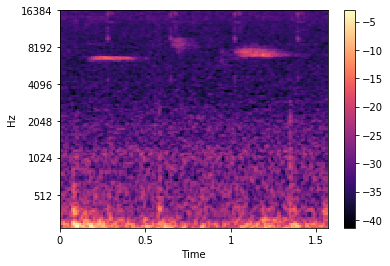

In [63]:
t_min, t_max = 44.544 / 60 * mel.shape[1], 45.1307 / 60 * mel.shape[1]
t_min, t_max = int(t_min), int(t_max)

f_min, fmax = 2531.25, 5531.25


pad = 40
crop = mel[:, t_min - pad:t_max + pad]
print(crop.shape)

librosa.display.specshow(crop, sr=mel_kwargs["sr"], fmin=mel_kwargs["fmin"], fmax=mel_kwargs["fmax"], y_axis="mel", x_axis="time")
plt.colorbar()

/home/user/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


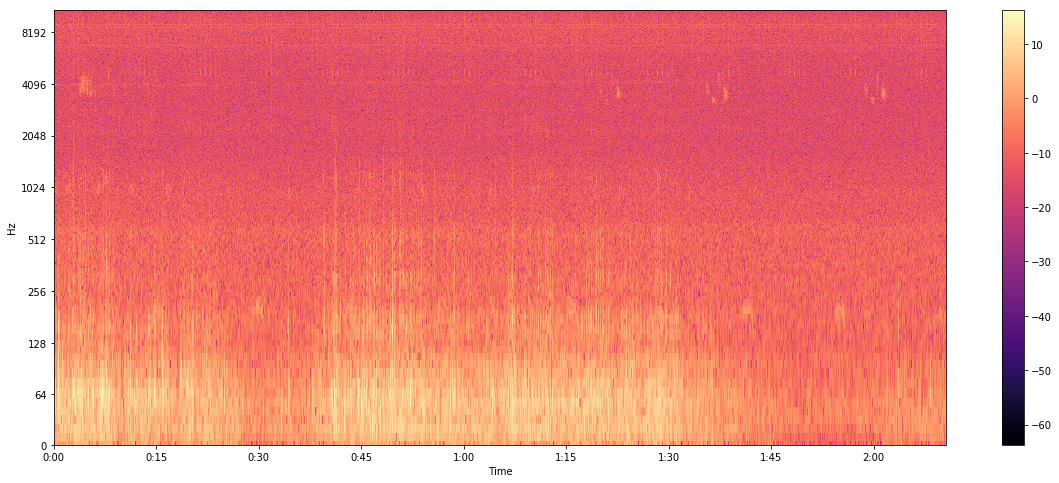

In [55]:
plt.figure(figsize=(20,8))
x = librosa.stft(audio, hop_length=512)
x = librosa.power_to_db(x)
librosa.display.specshow(x, y_axis="log", x_axis="time")
plt.colorbar()

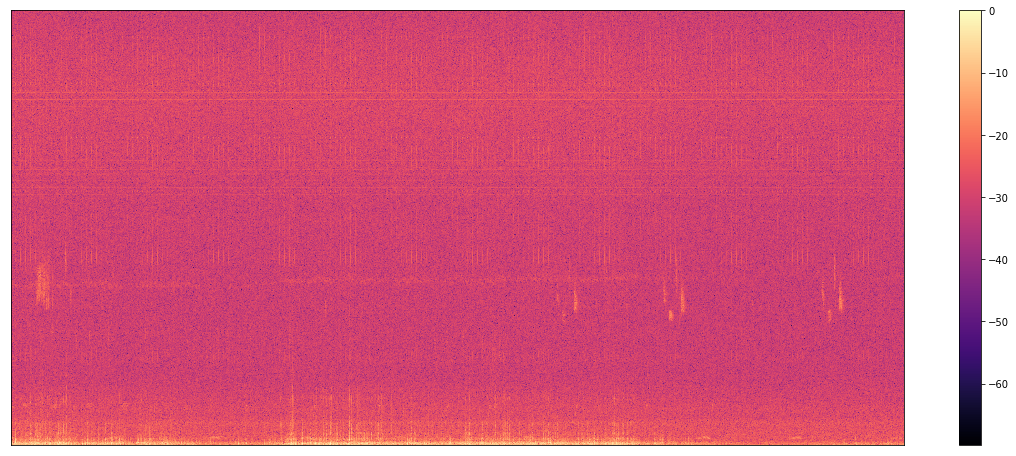

In [57]:
plt.figure(figsize=(20,8))
x = librosa.stft(audio, hop_length=512)
x = librosa.power_to_db(x, ref=np.max)
librosa.display.specshow(x)
plt.colorbar()

In [ ]:
from skimage.io import imread
imread("../data/mel_224_p1/test/000316da7.tif").min()

In [ ]:
def time_to_pix(time, sr, hop_length):
    return time * sr / hop_length

def pix_to_time(length, sr, hop_length):
    return hop_length * length / sr
    